# Package loading and basic configurations

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import matplotlib.pyplot as plt
import scipy
from scipy.misc import derivative
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks in the time interval. 

In [31]:
bbox = BboxSelector([
    7.603312, # min_x
    51.952343, # min_y
    7.65083, # max_x 
    51.974045,  # max_y 
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox,  num_results=50) # requesting 50 tracks inside the bbox



In [125]:
one_track_id = track_df['track.id'].unique()[4]
one_track = track_df[track_df['track.id'] == one_track_id]


## Add elevation

In [ ]:
import requests as req
url = 'https://api.opentopodata.org/v1/eudem25m?locations='
def get_elvdata(lat,lng):
    access = url+str(lat)+(',')+str(lng)
    elevation = req.request('GET',access)
    data = eval(elevation.text)
    return data['results'][0]['elevation']
for i in one_track.index:     
    one_track.loc[i,'elevation'] = get_elvdata(one_track.loc[i,'geometry'].y,one_track.loc[i,'geometry'].x)
#The request takes time
one_track

# Calculate gradient by GPS data & add time interval

In [130]:
def distance(lon1,lon2,lat1,lat2):
    R = 63713000 #radius
    φ1=lat1 * np.pi /180
    φ2 = lat2 * np.pi /180
    Δφ = (lat2-lat1) * np.pi /180
    Δλ = (lon2-lon1) * np.pi /180
    a = np.sin(Δφ/2) * np.sin(Δφ/2) +np.cos(φ1) * np.cos(φ2) *np.sin(Δλ/2) * np.sin(Δλ/2)
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a));
    return R * c
def gradient(height,distance):
    return np.arctan(height/distance) * 180/np.pi

for i in one_track.index:
    if (i == len(some_track)-1):
        break
    lat1= one_track.loc[i,'geometry'].y
    lat2= one_track.loc[i+1,'geometry'].y
    lon1= one_track.loc[i,'geometry'].x
    lon2= one_track.loc[i+1,'geometry'].x
    heightdiff = one_track.loc[i,'GPS Altitude.value']-one_track.loc[i+1,'GPS Altitude.value']
    one_track.loc[i+1,'seg_distance']= distance(lon1,lon2,lat1,lat2)
    one_track.loc[i,'gradient_gps']= gradient(heightdiff,some_track.loc[i+1,'seg_distance'])

## Add interval time
j = 5
for i in one_track.index:
    one_track.loc[i, 'time_interval'] = j
    j = j+5

# Convert the speed unit to m/s
for i in one_track.index:
    one_track.loc[i, 'speed'] = one_track.loc[i, 'GPS Speed.value'] * 0.27777
    
    
    


## Getting the velocity equation & Calculate the acceleration

In [131]:

## get the speed equation
time_interval = np.array(one_track['time_interval'])
speed = np.array(one_track['speed'])
idx = np.isfinite(time_interval) & np.isfinite(speed)

def get_equation(x,y):
    degree = 80
    coefs, res, _, _, _ = np.polyfit(x,y,degree, full = True)
    ffit = np.poly1d(coefs)
    #print (ffit)
    return ffit

speed_equation = get_equation(time_interval[idx], speed[idx])

## calculate the acceleration using the derivative
j = 0
for i in one_track.index:
    if one_track.loc[i, 'speed'] == 0:
        one_track.loc[i, 'Acceleration'] = 0
    else:
        one_track.loc[i, 'Acceleration'] = derivative(speed_equation, one_track.loc[i, 'time_interval'])
    j = j+5




## Filter the data

In [133]:
realistc_drive = one_track[['time','geometry','speed', 'track.length','seg_distance', 'sensor.fuelType', 'Acceleration', 'gradient_gps']]
realistc_drive 


,time,geometry,speed,track.length,seg_distance,sensor.fuelType,Acceleration,gradient_gps
0,2020-03-12T17:43:10,POINT (7.65178 51.93495),0.821248,4.821775,NaN,diesel,3.948788,13.934163
1,2020-03-12T17:43:15,POINT (7.65183 51.93497),0.597299,4.821775,41.261687,diesel,0.001335,-2.885945
2,2020-03-12T17:43:20,POINT (7.65185 51.93480),4.027571,4.821775,191.130686,diesel,-0.658674,3.548983
3,2020-03-12T17:43:26,POINT (7.65236 51.93475),6.703896,4.821775,356.752334,diesel,-0.155244,-0.479752
4,2020-03-12T17:43:31,POINT (7.65274 51.93444),5.521024,4.821775,427.576987,diesel,0.457819,-1.873488
...,...,...,...,...,...,...,...,...
130,2020-03-12T17:54:08,POINT (7.65297 51.95383),0.000000,4.821775,20.038401,diesel,0.000000,-0.000003
131,2020-03-12T17:54:13,POINT (7.65299 51.95383),0.000000,4.821775,17.502148,diesel,0.000000,0.002951
132,2020-03-12T17:54:18,POINT (7.65301 51.95381),0.001294,4.821775,19.937612,diesel,0.405947,-3.365468
133,2020-03-12T17:54:23,POINT (7.65301 51.95381),0.030658,4.821775,3.562060,diesel,-1.219897,0.883818


## Define General Parameters for the cars

In [ ]:
m = 1500      # mass of the car  "kg"
A = 2         # cross-sectional of the car "m²"
P_air = 1.2   # Air mass density "kg per m³" 
P_idle = 2    # Idle power "kW"
Cw = 0.3      # Air drag cofficient 
H_g = 8.8     # Calorific value gasoline "kWh/l"
H_d = 9.9     # Calorific value diesel "kWh/l"
g = 9.81      # Gravitational acceleration "m/s²"

##  Define Specific Parameters for Volkswagen

In [ ]:
m_volks = 1570      # mass of the car  "kg"
A_volks = 2.179       # cross-sectional of the car "m²"
Cw_volks = 0.32      # Air drag cofficient 


## Import OSM Network, in the same area of tracks

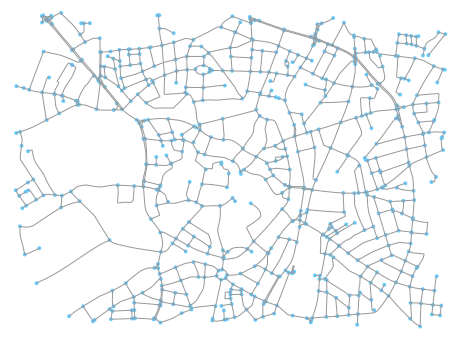

(<Figure size 576.497x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25bc620d148>)

In [11]:
import osmnx as ox

G = ox.graph_from_bbox(51.974045, 51.952343, 7.65083, 7.603312, network_type='drive')
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

## Convert the OSM Netwok to geodataframe and filter the attributes

In [14]:
nodes, streets = ox.graph_to_gdfs(G)
road_network = streets[['maxspeed','length','surface']]
road_network
#to check the type of surface "for rolling coff."
for i in road_network.index:
    if road_network.loc[i, 'surface'] == "asphalt":
        road_network.loc[i, 'rolling_resistance'] = 0.02 # source: engineeringtoolbox.com
    elif road_network.loc[i, 'surface'] == "cobblestone":
        road_network.loc[i, 'rolling_resistance'] = 0.015 # source: engineeringtoolbox.com
    elif road_network.loc[i, 'surface'] == "paving_stones":
        road_network.loc[i, 'rolling_resistance'] = 0.033 # source: The Automotive Chassis book
    else:
        road_network.loc[i, 'rolling_resistance'] = 0.02
        
road_network

,maxspeed,length,surface,rolling_resistance
0,50,6.146,asphalt,0.02
1,50,200.247,asphalt,0.02
2,30,12.933,asphalt,0.02
3,50,96.147,asphalt,0.02
4,NaN,119.161,asphalt,0.02
...,...,...,...,...
915,30,68.594,asphalt,0.02
916,30,56.319,asphalt,0.02
917,NaN,56.935,NaN,0.02
918,30,81.071,asphalt,0.02
